In [1]:
import sys
import math
import uproot
import operator
import numpy as np
import ROOT  as r
import matplotlib.pyplot as plt
from   scipy.optimize    import leastsq
from   scipy             import stats

Welcome to JupyROOT 6.22/00


In [2]:
def deltaphi(e_phi, m_phi) :
    d_phi =  e_phi - m_phi
    if (d_phi >  np.pi) : d_phi -= 2*np.pi
    if (d_phi < -np.pi) : d_phi += 2*np.pi
    return d_phi

In [3]:
def dR(e_phi, e_eta, m_phi, m_eta) :
    d_eta = abs(e_eta - m_eta)
    d_phi = deltaphi(e_phi, m_phi)
    return np.sqrt(d_phi**2 + d_eta**2)

In [4]:
# Implemented from https://gitlab.cern.ch/TopAnalysis/Configuration/analysis/common/src/KinematicReconstruction.cc

def angle_rot(e, vect_sm) :                       # alpha should be passed, vect_sm is the smeared 4 vector to returned by reference
    
    #if abs(vect_sm.Px()) < e  : vect_sm.setPx(0)
    #if abs(vect_sm.Py()) < e  : vect_sm.setPy(0)
    #if abs(vect_sm.Pz()) < e  : vect_sm.setPz(0)
    
    alpha = np.random.normal(0, 1)                 # should be related to vect_sm angular resolution
    phi   = 2 * np.pi * np.random.uniform(-1 , 1)   
    pz_1  = vect_sm.Vect().Mag() * np.cos(alpha)
    px_1  = vect_sm.Vect().Mag() * np.sin(alpha) * np.sin(phi)
    py_1  = vect_sm.Vect().Mag() * np.sin(alpha) * np.cos(phi)
    
    if (vect_sm.Py() != 0 or vect_sm.Pz() != 0) :
        d = np.sqrt(vect_sm.Pz()**2 + vect_sm.Py()**2)
        p = vect_sm.Vect().Mag()
        
        x1 = d/p 
        y1 = 0
        z1 = vect_sm.Px() / p
        
        x2 = -(vect_sm.Px() * vect_sm.Py()) / (d * p)
        y2 =   vect_sm.Pz() / d
        z2 =   vect_sm.Py() / p 
        
        x3 = -(vect_sm.Px() * vect_sm.Pz()) / (d * p)
        y3 = - vect_sm.Py() / d
        z3 =   vect_sm.Pz() / p     
        
        vect_sm.SetPx(x1*px_1 + y1*py_1 + z1*pz_1)
        vect_sm.SetPy(x2*px_1 + y2*py_1 + z2*pz_1)
        vect_sm.SetPz(x3*px_1 + y3*py_1 + z3*pz_1)
        vect_sm.SetE(vect_sm.E())
        
        
    if (vect_sm.Px()==0 and vect_sm.Py()==0 and vect_sm.Pz()==0):
        vect_sm.SetPx(vect_sm.Px())
        vect_sm.SetPy(vect_sm.Py())
        vect_sm.SetPz(vect_sm.Pz())
        vect_sm.SetE(vect_sm.E())
    
    if (vect_sm.Px()!=0 and vect_sm.Py()==0 and vect_sm.Pz()==0) : 
        vect_sm.SetPx(pz_1)
        vect_sm.SetPy(px_1)
        vect_sm.SetPz(py_1)
        vect_sm.SetE(vect_sm.E())

In [5]:
# Implemented from https://gitlab.cern.ch/TopAnalysis/Configuration/analysis/common/src/KinematicReconstruction.cc

def try_smear(jet1, jet2, lep1, lep2, metx, mety) :
    
    ttbar_mass = []
    chi_sq     = []
    
    if  ( ((lep1 + lep2).M() > 100) or ((jet1 + jet1).M() > 100) ) : return 0
    
    # Define met, not sure what Vx is
    met     = ROOT.TVector3(metx, mety ,0)
    vX_reco = - jet1.Vect() - jet2.Vect() - lep1.Vect() - lep2.Vect() - met
    
    for i in range(100) :
        
        met_sm  = ROOT.TLorentzVector()
        jet1_sm = ROOT.TLorentzVector(jet1)
        jet2_sm = ROOT.TLorentzVector(jet2)
        lep1_sm = ROOT.TLorentzVector(lep1)
        lep2_sm = ROOT.TLorentzVector(lep2)
        
        metV3_sm = ROOT.TVector3()
        
        # Jet energy based smearing 
        #fB1 = np.random.uniform(low= 1.0, high=1.04) # From Jet Energy Resolution
        fB1 = np.random.normal(1.0, 0.05)
        xB1 = np.sqrt((fB1**2 * jet1_sm.E()**2 - jet1_sm.M2()) / (jet1_sm.P() ** 2))

        jet1_sm.SetXYZT(jet1_sm.Px()*xB1, jet1_sm.Py()*xB1, jet1_sm.Pz()*xB1, jet1_sm.E()*fB1)
        angle_rot(0.001, jet1_sm)

        #fB2 = np.random.uniform(low= 1.0, high=1.04) # From Jet Energy Resolution
        fB2 = np.random.normal(1.0, 0.05)
        xB2 = np.sqrt((fB2**2 * jet2_sm.E()**2  - jet2_sm.M2()) / (jet2_sm.P() ** 2))

        jet2_sm.SetXYZT(jet2_sm.Px()*xB2, jet2_sm.Py()*xB2, jet2_sm.Pz()*xB2, jet2_sm.E()*fB2)
        angle_rot(0.001, jet2_sm)

        # Lepton energy based smearing 
        #fL1 = np.random.uniform(low= 1.0, high=1.02) # From Lep Energy Resolution
        fL1 = np.random.normal(1.0, 0.01)        
        xL1 = np.sqrt((fL1**2 * lep1_sm.E()**2  - lep1_sm.M2()) / (lep1_sm.P() ** 2))

        lep1_sm.SetXYZT(lep1_sm.Px()*xB1, lep1_sm.Py()*xB1, lep1_sm.Pz()*xB1, lep1_sm.E()*fB1)
        angle_rot(0.001, lep1_sm)

        #fL2 = np.random.uniform(low= 1.0, high=1.02) # From Lep Energy Resolution,
        fL2 = np.random.normal(1.0, 0.01)  
        xL2 = np.sqrt((fL2**2 * lep2_sm.E()**2  - lep2_sm.M2()) / (lep2_sm.P() ** 2))

        lep2_sm.SetXYZT(lep2_sm.Px()*xB2, lep2_sm.Py()*xB2, lep2_sm.Pz()*xB2, lep2_sm.E()*fB2)
        angle_rot(0.001, lep2_sm)

        # Adjust MET so that it is still balanced
        metV3_sm = -jet1_sm.Vect() - jet2_sm.Vect() - lep1_sm.Vect() - lep2_sm.Vect()- vX_reco
        
        met_sm.SetXYZM(metV3_sm.Px(),metV3_sm.Py(),0,0)

        #Maybe see if a solution exists or not
        try    :
            d          = doubleNeutrinoSolutions(jet1_sm, jet2_sm, lep1_sm, lep2_sm, met_sm.Px(), met_sm.Py())
            neutrino1  = Convertnuto4vec(d.nunu_s,0)
            neutrino2  = Convertnuto4vec(d.nunu_s,1)

            top1 = jet1_sm + lep1_sm + neutrino1
            top2 = jet2_sm + lep2_sm + neutrino2
            ttbar_mass.append((top1   + top2).M())

        except np.linalg.LinAlgError :
            # Alternative pairing
            try :
                d_alt      = doubleNeutrinoSolutions(jet2_sm, jet1_sm, lep1_sm, lep2_sm, met_sm.Px(), met_sm.Py())
                neutrino1  = Convertnuto4vec(d_alt.nunu_s,0)
                neutrino2  = Convertnuto4vec(d_alt.nunu_s,1)

                top1 = jet2_sm + lep1_sm + neutrino1
                top2 = jet1_sm + lep2_sm + neutrino2
                ttbar_mass.append((top1   + top2).M())

            except np.linalg.LinAlgError as err:
                if 'Singular matrix' in str(err): 
                    continue
                else:
                    raise

    ttbar_mass = np.array(ttbar_mass)
    if len(ttbar_mass) == 0 :
        return 0
    else : 
        return ttbar_mass.min()

In [6]:
mT = 172.5   # GeV : top quark mass
mW = 80.385  # GeV : W boson mass
mN = 0       # GeV : neutrino mass


def UnitCircle():
    '''Unit circle in extended representation'''
    return np.diag([1, 1, -1])


def cofactor(A, i, j):
    '''Cofactor[i,j] of 3x3 matrix A'''
    a = A[not i:2 if i==2 else None:2 if i==1 else 1,
          not j:2 if j==2 else None:2 if j==1 else 1]
    return (-1)**(i+j) * (a[0,0]*a[1,1] - a[1,0]*a[0,1])


def R(axis, angle):
    '''Rotation matrix about x(0),y(1), or z(2) axis'''
    c, s = math.cos(angle), math.sin(angle)
    R = c * np.eye(3)
    for i in [-1, 0, 1]:
        R[(axis-i) % 3, (axis+i) % 3] = i*s + (1 - i*i)
    return R


def Derivative():
    '''Matrix to differentiate [cos(t),sin(t),1]'''
    return R(2, math.pi / 2).dot(np.diag([1, 1, 0]))


def multisqrt(y):
    '''Valid real solutions to y=x*x'''
    return ([] if y < 0 else
            [0] if y == 0 else
            (lambda r: [-r, r])(math.sqrt(y)))


def factor_degenerate(G, zero=0):
    '''Linear factors of degenerate quadratic polynomial'''
    if G[0,0] == 0 == G[1,1]:
        return [[G[0,1], 0, G[1,2]],
                [0, G[0,1], G[0,2] - G[1,2]]]

    swapXY = abs(G[0,0]) > abs(G[1,1])
    Q = G[(1,0,2),][:,(1,0,2)] if swapXY else G
    Q /= Q[1,1]
    q22 = cofactor(Q, 2, 2)

    if -q22 <= zero:
        lines = [[Q[0,1], Q[1,1], Q[1,2]+s]
                 for s in multisqrt(-cofactor(Q, 0, 0))]
    else:
        x0, y0 = [cofactor(Q, i, 2) / q22 for i in [0, 1]]
        lines = [[m, Q[1,1], -Q[1,1]*y0 - m*x0]
                 for m in [Q[0,1] + s
                           for s in multisqrt(-q22)]]

    return [[L[swapXY],L[not swapXY],L[2]] for L in lines]


def intersections_ellipse_line(ellipse, line, zero=1e-12):
    '''Points of intersection between ellipse and line'''
    _,V = np.linalg.eig(np.cross(line,ellipse).T)
    sols = sorted([(v.real / v[2].real,
                    np.dot(line,v.real)**2 +
                    np.dot(v.real,ellipse).dot(v.real)**2)
                    for v in V.T],
                    key=lambda s: s[1])[:2]
    return [s for s, k in sols if k < zero]


def intersections_ellipses(A, B, returnLines=False):
    '''Points of intersection between two ellipses'''
    LA = np.linalg
    if abs(LA.det(B)) > abs(LA.det(A)): A,B = B,A
    e = next(e.real for e in LA.eigvals(LA.inv(A).dot(B))
             if not e.imag)
    lines = factor_degenerate(B - e*A)
    points = sum([intersections_ellipse_line(A,L)
                  for L in lines],[])
    return (points,lines) if returnLines else points


class nuSolutionSet(object):
    '''Definitions for nu analytic solution, t->b,mu,nu'''

    def __init__(self, b, mu, mW2=mW**2, mT2=mT**2, mN2=mN**2):
        
        c = r.Math.VectorUtil.CosTheta(b,mu)
        s = math.sqrt(1-c**2)

        x0p = - (mT2 - mW2 - b.M2()) / (2*b.E())
        x0  = - (mW2 - mu.M2() - mN2) / (2*mu.E())

        Bb, Bm = b.Beta(), mu.Beta()

        Sx = (x0 * Bm - mu.P()*(1-Bm**2)) / Bm**2
        Sy = (x0p / Bb - c * Sx) / s

        w  = (Bm / Bb - c) / s
        w_ = (-Bm / Bb - c) / s

        Om2  = w**2 + 1 - Bm**2
        eps2 = (mW2 - mN2) * (1 - Bm**2)
        x1   = Sx - (Sx+w*Sy) / Om2
        y1   = Sy - (Sx+w*Sy) * w / Om2
        Z2   = x1**2 * Om2 - (Sy-w*Sx)**2 - (mW2-x0**2-eps2)
        Z    = math.sqrt(max(0, Z2))

        for item in ['b','mu','c','s','x0','x0p',
                     'Sx','Sy','w','w_','x1','y1',
                     'Z','Om2','eps2','mW2']:
            setattr(self, item, eval(item))

    @property
    def K(self):
        '''Extended rotation from F' to F coord.'''
        return np.array([[self.c, -self.s, 0, 0],
                         [self.s,  self.c, 0, 0],
                         [     0,       0, 1, 0],
                         [     0,       0, 0, 1]])

    @property
    def A_mu(self):
        '''F coord. constraint on W momentum: ellipsoid'''
        B2   = self.mu.Beta()**2
        SxB2 = self.Sx * B2
        F    = self.mW2 - self.x0**2 - self.eps2
        return np.array([[1-B2, 0, 0, SxB2],
                         [   0, 1, 0,    0],
                         [   0, 0, 1,    0],
                         [SxB2, 0, 0,    F]])

    @property
    def A_b(self):
        '''F coord. constraint on W momentum: ellipsoid'''
        K, B = self.K, self.b.Beta()
        mW2, x0p = self.mW2, self.x0p
        A_b_ = np.array([[1-B*B,  0,  0,      B*x0p],
                         [    0,  1,  0,          0],
                         [    0,  0,  1,          0],
                         [B*x0p,  0,  0, mW2-x0p**2]])
        return K.dot(A_b_).dot(K.T)

    @property
    def R_T(self):
        '''Rotation from F coord. to laboratory coord.'''
        b_xyz = self.b.X(), self.b.Y(), self.b.Z()
        R_z   = R(2, -self.mu.Phi())
        R_y   = R(1, 0.5*math.pi - self.mu.Theta())
        R_x   = next(R(0,-math.atan2(z,y))
                   for x,y,z in (R_y.dot(R_z.dot(b_xyz)),))
        return R_z.T.dot(R_y.T.dot(R_x.T))

    @property
    def H_tilde(self):
        '''Transformation of t=[c,s,1] to p_nu: F coord.'''
        x1, y1, p = self.x1, self.y1, self.mu.P()
        Z, w, Om  = self.Z , self.w , math.sqrt(self.Om2)
        return np.array([[  Z/Om, 0, x1-p],
                         [w*Z/Om, 0,   y1],
                         [     0, Z,    0]])

    @property
    def H(self):
        '''Transformation of t=[c,s,1] to p_nu: lab coord.'''
        return self.R_T.dot(self.H_tilde)

    @property
    def H_perp(self):
        '''Transformation of t=[c,s,1] to pT_nu: lab coord.'''
        return np.vstack([self.H[:2], [0, 0, 1]])

    @property
    def N(self):
        '''Solution ellipse of pT_nu: lab coord.'''
        HpInv = np.linalg.inv(self.H_perp)
        return HpInv.T.dot(UnitCircle()).dot(HpInv)


class doubleNeutrinoSolutions(object):
    '''Solution pairs of neutrino momenta, tt -> leptons'''
    def __init__(self, b, b_ , mu, mu_, metX, metY, mW2=mW**2, mT2=mT**2):
        
        self.solutionSets = [nuSolutionSet(B, M, mW2, mT2)
                             for B,M in zip((b,b_),(mu,mu_))]

        V0     = np.outer([metX, metY, 0], [0, 0, 1])
        self.S = V0 - UnitCircle()

        N, N_ = [ss.N for ss in self.solutionSets]
        n_    = self.S.T.dot(N_).dot(self.S)

        v  = intersections_ellipses(N, n_)
        v_ = [self.S.dot(sol) for sol in v]

        if not v and leastsq:
            es  = [ss.H_perp for ss in self.solutionSets]
            met = np.array([metX, metY, 1])

            def nus(ts):
                return tuple(e.dot([math.cos(t), math.sin(t), 1])
                             for e, t in zip(es, ts))

            def residuals(params):
                return sum(nus(params), -met)[:2]

            ts,_  = leastsq(residuals, [0, 0], ftol=5e-5, epsfcn=0.01)
            v, v_ = [[i] for i in nus(ts)]
      
        for k, v in {'perp': v, 'perp_': v_, 'n_': n_}.items():
            setattr(self, k, v)

    @property
    def nunu_s(self):
        '''Solution pairs for neutrino momenta'''
        K, K_ = [ss.H.dot(np.linalg.inv(ss.H_perp))
                 for ss in self.solutionSets]
        return [(K.dot(s), K_.dot(s_))
                for s, s_ in zip(self.perp, self.perp_)]

In [7]:
def Convertnuto4vec(nu,i):
    neutrino = ROOT.TLorentzVector()
    Px = nu[0][i][0]
    Py = nu[0][i][1]
    Pz = nu[0][i][2]
    E  = math.sqrt(Px**2 + Py**2 + Pz**2)
    neutrino.SetPxPyPzE(Px,Py,Pz,E)
    return neutrino

In [8]:
def Convertnuto4vec_new(nu):
    nu_arr = []
    # Solution number, nuetrino number, Px/y/z
    for i in range(len(nu)):
        for j in range(2): 
            neutrino = ROOT.TLorentzVector()
            Px = nu[i][j][0]
            Py = nu[i][j][1]
            Pz = nu[i][j][2]
            E  = math.sqrt(Px**2 + Py**2 + Pz**2)
            neutrino.SetPxPyPzE(Px,Py,Pz,E)
            nu_arr.append(neutrino)
    return nu_arr

In [9]:
tt_ptr        = uproot.open('ttbar_final.root')['Step8']

tt_ST         = tt_ptr['ST'].array()
tt_MET        = tt_ptr['MET'].array()
tt_MET_phi    = tt_ptr['MET_phi'].array()

tt_l_pt       = tt_ptr['l_pt'].array()
tt_l_eta      = tt_ptr['l_eta'].array()
tt_l_phi      = tt_ptr['l_phi'].array()
tt_l_mass     = tt_ptr['l_mass'].array()

tt_sl_pt      = tt_ptr['sl_pt'].array()
tt_sl_eta     = tt_ptr['sl_eta'].array()
tt_sl_phi     = tt_ptr['sl_phi'].array()
tt_sl_mass    = tt_ptr['sl_mass'].array()

tt_ljet_pt    = tt_ptr['ljet_pt'].array()
tt_ljet_eta   = tt_ptr['ljet_eta'].array()
tt_ljet_phi   = tt_ptr['ljet_phi'].array()

tt_sljet_pt   = tt_ptr['sljet_pt'].array()
tt_sljet_eta  = tt_ptr['sljet_eta'].array()
tt_sljet_phi  = tt_ptr['sljet_phi'].array()

## EXACT WHEN POSSIBLE, SMEAR THE REST

In [10]:
import ROOT

no_sol    = 0
tt_mass   = []
selection = np.zeros(100000)

needs_smear= 0 

for i in range (100000) :
    first_pair = 0
    sec_pair   = 0
    
    jet1 = ROOT.TLorentzVector()
    jet2 = ROOT.TLorentzVector()
    lep1 = ROOT.TLorentzVector()
    lep2 = ROOT.TLorentzVector()
    
    top1 = ROOT.TLorentzVector()
    top2 = ROOT.TLorentzVector()
    
    atop1 = ROOT.TLorentzVector()
    atop2 = ROOT.TLorentzVector()
    
    jet1.SetPtEtaPhiM(tt_ljet_pt[i] , tt_ljet_eta[i] , tt_ljet_phi[i] , 4.2)
    jet2.SetPtEtaPhiM(tt_sljet_pt[i], tt_sljet_eta[i], tt_sljet_phi[i], 4.2)
    
    lep1.SetPtEtaPhiM(tt_l_pt[i] , tt_l_eta[i] , tt_l_phi[i] , tt_l_mass[i])
    lep2.SetPtEtaPhiM(tt_sl_pt[i], tt_sl_eta[i], tt_sl_phi[i], tt_sl_mass[i])
    
    met_x   =  tt_MET[i] * np.cos(tt_MET_phi[i])
    met_y   =  tt_MET[i] * np.sin(tt_MET_phi[i])

    #Maybe see if a solution exists or not
    try    :
        d  = doubleNeutrinoSolutions(jet1, jet2, lep1, lep2, met_x, met_y)
        first_pair  += 1
        
    except np.linalg.LinAlgError : pass
        
    # If not the first pairing, then the other one
    try :
        d_alt = doubleNeutrinoSolutions(jet2, jet1, lep1, lep2, met_x, met_y)
        sec_pair += 1
        
    except np.linalg.LinAlgError: pass
    
    if (first_pair == 1 and sec_pair == 0) :
        neutrino1  = Convertnuto4vec(d.nunu_s,0)
        neutrino2  = Convertnuto4vec(d.nunu_s,1)
        top1       = jet1 + lep1 + neutrino1
        top2       = jet2 + lep2 + neutrino2
        tt_mass.append((top1   + top2).M())
        selection[i] = 1
        
    elif(sec_pair == 1  and first_pair == 0) :
        neutrino1  = Convertnuto4vec(d_alt.nunu_s,0)
        neutrino2  = Convertnuto4vec(d_alt.nunu_s,1)
        top1       = jet1 + lep1 + neutrino1
        top2       = jet2 + lep2 + neutrino2
        tt_mass.append((top1   + top2).M())
        selection[i] = 1
        
    elif(first_pair == 1 and sec_pair == 1) :
        dr1 = dR(jet1.Phi(), jet1.Eta(), lep1.Phi(), lep1.Eta()) + dR(jet2.Phi(), jet2.Eta(), lep2.Phi(), lep2.Eta())
        dr2 = dR(jet1.Phi(), jet1.Eta(), lep2.Phi(), lep2.Eta()) + dR(jet2.Phi(), jet2.Eta(), lep1.Phi(), lep1.Eta())
        
        if (dr1 < dr2) :
            neutrino1  = Convertnuto4vec(d.nunu_s,0)
            neutrino2  = Convertnuto4vec(d.nunu_s,1)
        else:
            neutrino1  = Convertnuto4vec(d_alt.nunu_s,0)
            neutrino2  = Convertnuto4vec(d_alt.nunu_s,1)
            
        top1 = jet1 + lep1 + neutrino1
        top2 = jet2 + lep2 + neutrino2
        
        tt_mass.append((top1   + top2).M())
        selection[i] = 1
    
    # Finally try smearing by JER or LER
    if (first_pair == 0 and sec_pair == 0) :
        try :
            tt_min = try_smear(jet1, jet2, lep1, lep2, met_x, met_y)
            tt_mass.append(tt_min)
            selection[i] = 1
            needs_smear += 1

        except np.linalg.LinAlgError as err:
            if 'Singular matrix' in str(err): 
                no_sol += 1
                continue
            else:
                raise

<ipython-input-6-d2c98e6ea2ab>:59: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return [[L[swapXY],L[not swapXY],L[2]] for L in lines]
/Users/amandeepsinghbakshi/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


In [11]:
np.savetxt('ttbar_mass_exact_and_smear_sol.txt', tt_mass)

In [12]:
tt_gen_mass = np.loadtxt('ttbar_final_gen_mass.txt')

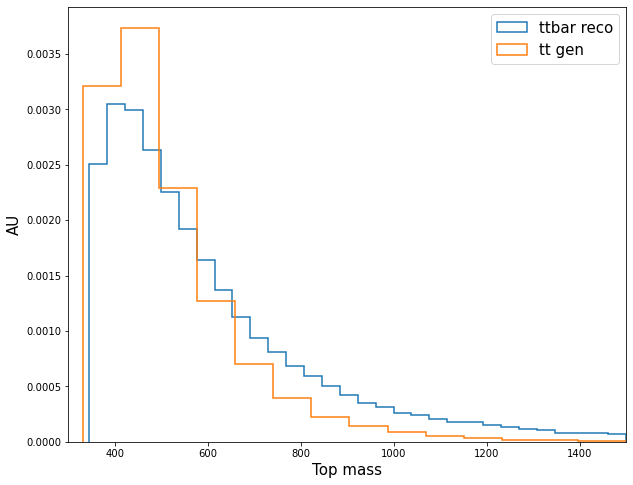

In [81]:
tt_mass = np.array(tt_mass)
fig, ax = plt.subplots(figsize=(10,8))
mask1   = tt_mass > 200
mask2   = tt_mass < 1500
mask_fin = mask1 & mask2

tt_gen_red = tt_gen_mass[:100000]
ax.hist(tt_mass[mask_fin]   , histtype='step', label='ttbar reco', linewidth=1.5, bins=30, density=True)
ax.hist(tt_gen_red[mask_fin], histtype='step', label='tt gen'    , linewidth=1.5, bins=30, density=True)
ax.set_xlim(300, 1500)
plt.xlabel('Top mass',  fontsize=15)
plt.ylabel('AU',  fontsize=15)
plt.legend(loc='upper right', fontsize=15)

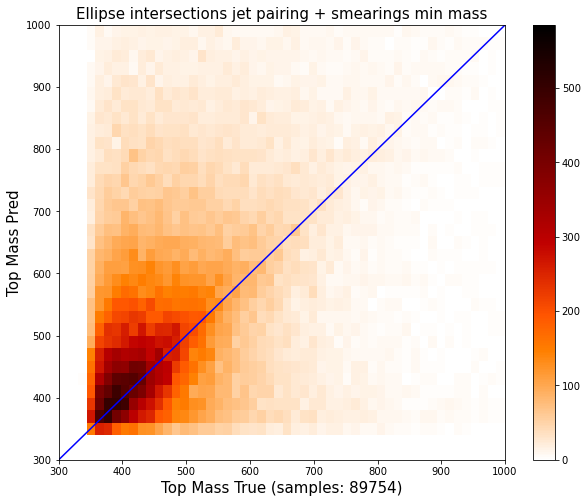

In [165]:
tt_mass    = np.array(tt_mass)
tt_gen_red = tt_gen_mass[:100000]
mask_reco  = tt_mass < 1000
mask_gen   = tt_gen_red < 1000
mask_fin   = mask_reco & mask_gen
samples    = len(tt_mass[mask_fin])

heatmap,xedges,yedges = np.histogram2d(tt_gen_red[mask_fin], tt_mass[mask_fin],bins=50)
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.figure(figsize=(10,8))
plt.imshow(heatmap.T ,extent=extent, origin='lower', aspect='auto')
plt.plot([0,1500],[0,1500],color='blue')
plt.set_cmap('gist_heat_r')
plt.xlabel("Top Mass True (samples: %.i)" %samples, fontsize=15)
plt.ylabel("Top Mass Pred", fontsize=15)
plt.title("Ellipse intersections jet pairing + smearings min mass", fontsize=15)
plt.xlim(300,1000)
plt.ylim(300,1000)
plt.colorbar()
#plt.savefig('ellipse_int_heatmap_pairings.png')

In [27]:
idx  = 1
jet1 = ROOT.TLorentzVector()
jet2 = ROOT.TLorentzVector()
lep1 = ROOT.TLorentzVector()
lep2 = ROOT.TLorentzVector()

jet1.SetPtEtaPhiM(tt_ljet_pt[idx] , tt_ljet_eta[idx] , tt_ljet_phi[idx] , 5)
jet2.SetPtEtaPhiM(tt_sljet_pt[idx], tt_sljet_eta[idx], tt_sljet_phi[idx], 5)

lep1.SetPtEtaPhiM(tt_l_pt[idx] , tt_l_eta[idx] , tt_l_phi[idx] , tt_l_mass[idx])
lep2.SetPtEtaPhiM(tt_sl_pt[idx], tt_sl_eta[idx], tt_sl_phi[idx], tt_sl_mass[idx])

met_x   =  tt_MET[idx] * np.cos(tt_MET_phi[idx]) 
met_y   =  tt_MET[idx] * np.sin(tt_MET_phi[idx]) 
  
print('M_visible::' + str(tt_ST[idx]))

d = doubleNeutrinoSolutions(jet1, jet2, lep1, lep2, met_x, met_y) 
n = Convertnuto4vec_new(d.nunu_s)
mass_arr = []

for i in range(0, len(n), 2) :
    top1 = ROOT.TLorentzVector()
    top2 = ROOT.TLorentzVector()

    top1 = jet1 + lep1 + n[i]
    top2 = jet2 + lep2 + n[i+1]
    
    mass_arr.append((top1 + top2).M())
    
print('ttbar Energy ::' + str((top1 + top2).E()))    
print('Possible mass points ::')
print(mass_arr)
print('Gen mass ::' + str(tt_gen_mass[idx]))

M_visible::598.394
ttbar Energy ::474.5668586069356
Possible mass points ::
[472.66680346934174]
Gen mass ::400.8165486357359


In [22]:
file_2016   = uproot.open('emu_steps.root')['ttBar_treeVariables_step8']
m_ttbar     = file_2016['ttbar_mass'].array()
gen_m_ttbar = file_2016['gen_ttbar_mass'].array()

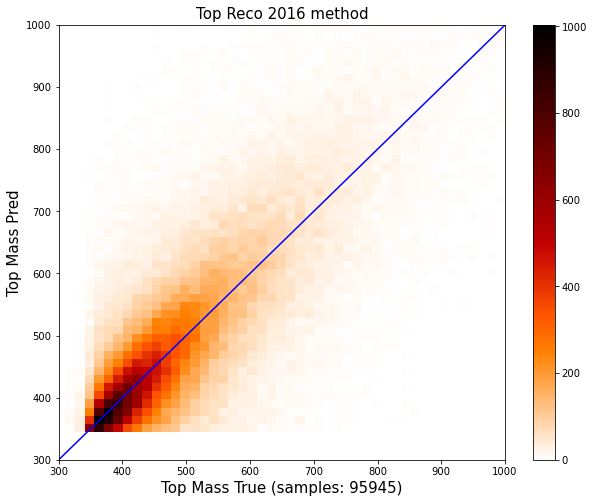

In [164]:
m_ttbar_red     = m_ttbar[:100000]
mask_reco       = m_ttbar_red < 1000
gen_m_ttbar_red = gen_m_ttbar[:100000]
mask_gen        = gen_m_ttbar_red < 1000
mask_fin        = mask_reco & mask_gen
samples         = len(m_ttbar_red[mask_fin])

heatmap,xedges,yedges =np.histogram2d(gen_m_ttbar_red[mask_fin],m_ttbar_red[mask_fin],bins=50)
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.figure(figsize=(10,8))
plt.imshow(heatmap.T ,extent=extent, origin='lower', aspect='auto')
plt.plot([0,1000],[0,1000],color='blue')
plt.set_cmap('gist_heat_r')
plt.xlabel("Top Mass True (samples: %.i)" %samples, fontsize=15)
plt.ylabel("Top Mass Pred", fontsize=15)
plt.title("Top Reco 2016 method" , fontsize=15)
plt.xlim(300,1000)
plt.ylim(300,1000)
plt.colorbar()
    
#plt.savefig('heatmap_2016_technique.jpg')

In [89]:
def multigraph(pred, true, title, lower, upper, bins):
    bins = np.histogram(true, bins=bins)[1]
    bincountsx,binedgesx,binnumx = stats.binned_statistic(pred, pred, statistic='count', bins=bins)
    bincountsy,binedgesy,binnumy = stats.binned_statistic(true, true, statistic='count', bins=bins)
    
    fig,axs = plt.subplots(2, gridspec_kw={'height_ratios':[3,1]}, figsize=(10,10))
    fig.suptitle(title, fontsize=15)
    axs[0].hist(pred, bins=bins, density=1, histtype='step', label = "ttbar mass reco", linewidth=1.5)
    axs[0].hist(true, bins=bins, density=1, histtype='step', label = "ttbar mass gen ", linewidth=1.5)
    axs[0].set_ylabel("AU", fontsize=15)
    axs[0].set_xlabel("ttbar mass", fontsize=15)
    axs[0].legend(fontsize=15)
    axs[0].set_xlim([lower,upper])

    axs[0].tick_params(axis='x', labelsize=13)
    axs[0].tick_params(axis='y', labelsize=13)
    
    binratio   = bincountsx/bincountsy
    bincenters = (bins[1:]+bins[:-1])/2
    bincentersfinal = bincenters[binratio!=0]
    
    biniszero =  binratio==0
    binratio  =  binratio[binratio!=0]
    binisnan  =  np.isnan(binratio)
    binnonan  =~ binisnan
    
    axs[1].scatter(bincentersfinal[binnonan],binratio[binnonan])
    axs[1].axhline(y=1)
    axs[1].set_xlim(lower,upper)
    axs[1].set_ylim(0.5  ,binratio.max())

    axs[1].tick_params(axis='x', labelsize=13)
    axs[1].tick_params(axis='y', labelsize=13)
    
    _,pval=stats.ks_2samp(true,pred)
    #axs[1].set_xlabel("P-value: %.2e" % pval)
    #fig.savefig("Plots/%s_plots.jpg" % title,bbox_inches='tight')

In [30]:
for i in range(len(tt_mass)):
    if i==3 or i==7:
        bins=100
        lower=-1
        upper=5
    elif i==11 or i==15:
        bins=20
        lower=-1.5
        upper=4
    else:
        bins=50
        lower=-6
        upper=6

In [31]:
def cuts(datain, datacheck, minval, maxval):
    dataout = datain[np.logical_and(datacheck>minval,datacheck<maxval)]
    return(dataout)

def sem(values):
    sem     = stats.sem(values)
    return(sem)

def plotgaussian(resids,title):
    from matplotlib.pyplot import figure
    figure(figsize=(8, 6))
    resids.sort()
    resmean = np.mean(resids)
    resstd  = np.std(resids)
    pdf     = stats.norm.pdf(resids,resmean,resstd)
    
    plt.hist(resids,bins=50,histtype='step',color='blue',density=1,label='Residuals')
    plt.plot(resids,pdf,label="Normal Curve",color='black')
    plt.title(title)
    plt.xlim(-800,800)
    plt.axvline(resmean, label="Mean: %.2f" % resmean, color='red') 
    
    fwhm    = 2*np.sqrt(2*np.log(2))*resstd
    samples = len(resids)
    
    plt.xlabel("FWHM: %.2f (samples: %.i)" % (fwhm,samples))
    plt.axvspan(resmean-fwhm/2,resmean+fwhm/2,facecolor='g',alpha=.5,label='FWHM')
    plt.legend()

In [62]:
from scipy.stats import norm
def fit_gaussian(x):
    mean, std = norm.fit(x)
    return mean, std

def plot_gaussian(x, mean, std):
    x.sort()
    plt.figure(figsize=(8, 6))
    pdf = stats.norm.pdf(x ,mean, std)

    plt.hist(x, bins=30, histtype='step'     ,color='blue' ,density=1, label='Residuals')
    plt.plot(x, pdf    , label="Normal Curve",color='black')
    plt.xlim(-600,600)
    plt.axvline(mean, label="Mean: %.2f" % mean, color='red') 

    fwhm    = 2*np.sqrt(2*np.log(2))*std
    samples = len(x)

    plt.xlabel("STD: %.2f (samples: %.i)" % (std,samples))
    plt.axvspan(mean - fwhm/2, mean + fwhm/2,facecolor='g',alpha=.5,label='FWHM')
    plt.legend()

In [166]:
bins  = [0, 450, 550, 800, 1500]
width = []
err_x = []
err_y = []

for i in range(len(bins) - 1) :
    residual  = m_ttbar -  gen_m_ttbar
    temp_res  = cuts(residual, gen_m_ttbar, bins[i], bins[i+1])
    temp_mask1 = temp_res < 1500
    temp_mask  = temp_mask1 
    mean, std  = fit_gaussian(temp_res[temp_mask]) 
    width.append(std)
    err_x.append((bins[i+1] - bins[i]) * 0.5)
    err_y.append(1./np.sqrt(len(temp_res)))

In [173]:
d_width = []
d_err_x = []
d_err_y = []
bin_centers = []

mask_reco  = tt_mass < 1000
mask_gen   = tt_gen_red < 1000
mask_fin   = mask_reco & mask_gen
samples    = len(tt_mass[mask_fin])

for i in range(len(bins) - 1) :
    residual  = tt_mass[mask_fin] -  tt_gen_red[mask_fin]
    temp_res  = cuts(residual, tt_gen_red[mask_fin] , bins[i], bins[i+1])
    temp_mask1 = temp_res < 1500
    temp_mask  = temp_mask1
    mean, std = fit_gaussian(temp_res[temp_mask]) 
    d_width.append(std)
    d_err_x.append((bins[i+1] - bins[i]) * 0.5)
    d_err_y.append(1./np.sqrt(len(temp_res)))
    bin_centers.append((bins[i] + bins[i+1]) * 0.5)

Text(0.5, 0, 'ttbar mass (GeV) ')

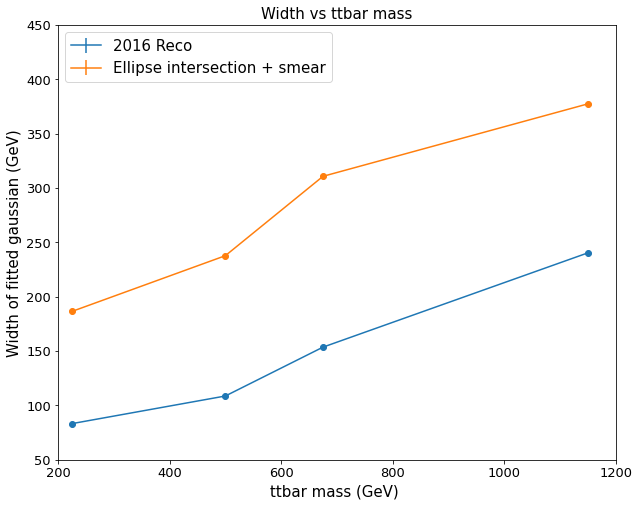

In [175]:
fig,axs = plt.subplots(figsize=(10,8))
axs.scatter(bin_centers , width)
axs.errorbar(bin_centers, width, yerr=err_y, label='2016 Reco')
axs.scatter(bin_centers , d_width)
axs.errorbar(bin_centers, d_width, yerr=d_err_y, label='Ellipse intersection + smear')

axs.tick_params(axis='both', which='major', labelsize=13)
axs.legend(fontsize=15, loc='upper left')
axs.set_xlim(200, 1200)
axs.set_ylim(50 , 450)
axs.set_title("Width vs ttbar mass", fontsize=15)
axs.set_ylabel("Width of fitted gaussian (GeV)", fontsize=15)
axs.set_xlabel("ttbar mass (GeV) ", fontsize=15)

In [72]:
residuals = tt_mass - tt_gen_red
fin_mask  = residuals < 1500
len(residuals[fin_mask]) / len(residuals)

0.9931

In [75]:
len(tt_mass[tt_mass != 0]) / len(tt_gen_mass[:100000]) # Solutions not found

0.85224

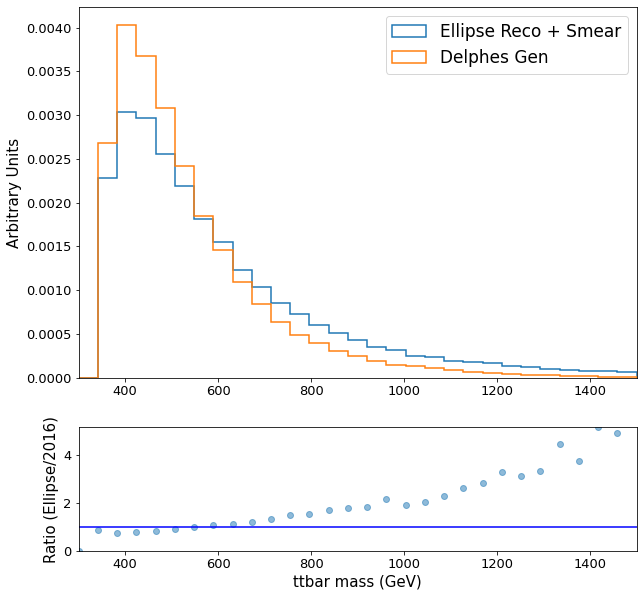

In [163]:
x_low    =  300
x_high   =  1500

binning = np.linspace(x_low,x_high, 30)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}

mask1    = tt_mass > 0
mask2    = tt_mass < 1500
mask_rec = mask1 & mask2

tt_gen_red = tt_gen_mass[:100000]
mask_gen   = tt_gen_red < 1500

mask_fin   = mask_gen & mask_reco
fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(tt_mass[mask_fin]   , density=True, histtype='step', bins=binning, label='Ellipse Reco + Smear', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(tt_gen_red[mask_fin], density=True, histtype='step', bins=binning, label='Delphes Gen', linewidth=1.5)

ax1.legend(prop={'size': 17}, loc='upper right')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],     # this is what makes it comparable
        ns1 / ns2,         # maybe check for div-by-zero!
        alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Ellipse/2016)', fontsize=15)
ax2.set_xlabel('ttbar mass (GeV)', fontsize=15)
ax2.set_ylim(0, max(ns1/ns2))
ax2.set_xlim(x_low,x_high)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

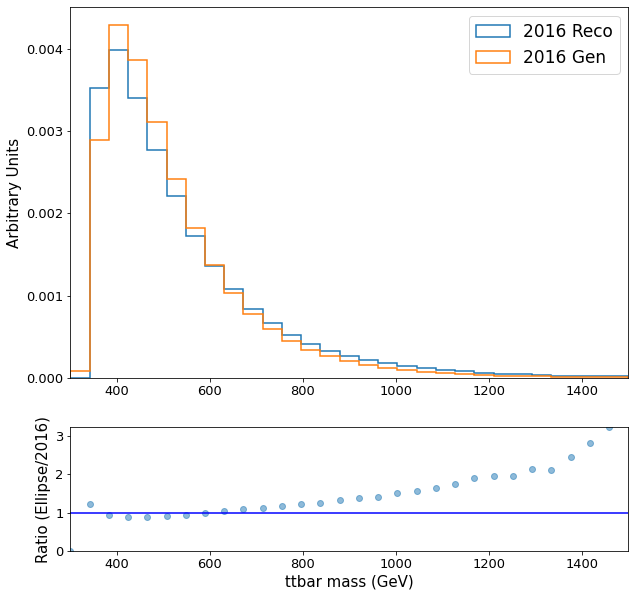

In [162]:
x_low    =  300
x_high   =  1500

binning = np.linspace(x_low,x_high, 30)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}

mask_rec   = m_ttbar < 1500
mask_gen   = gen_m_ttbar < 1500
mask_fin   = mask_rec & mask_gen

fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(m_ttbar[mask_fin]    , density=True, histtype='step', bins=binning, label='2016 Reco', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(gen_m_ttbar[mask_fin], density=True, histtype='step', bins=binning, label='2016 Gen' , linewidth=1.5)

ax1.legend(prop={'size': 17}, loc='upper right')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],     # this is what makes it comparable
        ns1 / ns2,         # maybe check for div-by-zero!
        alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Ellipse/2016)', fontsize=15)
ax2.set_xlabel('ttbar mass (GeV)', fontsize=15)
ax2.set_ylim(0, max(ns1/ns2))
ax2.set_xlim(x_low,x_high)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

In [183]:
p3_pPro = ROOT.TVector3(0., 0., 1.)
top1.Vect().Unit().Dot(p3_pPro)

-0.6750389965975584